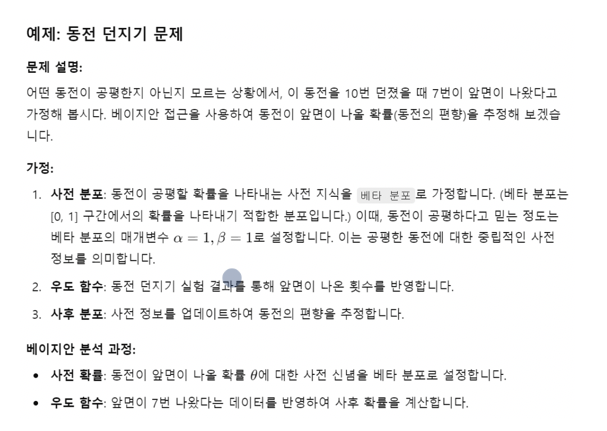

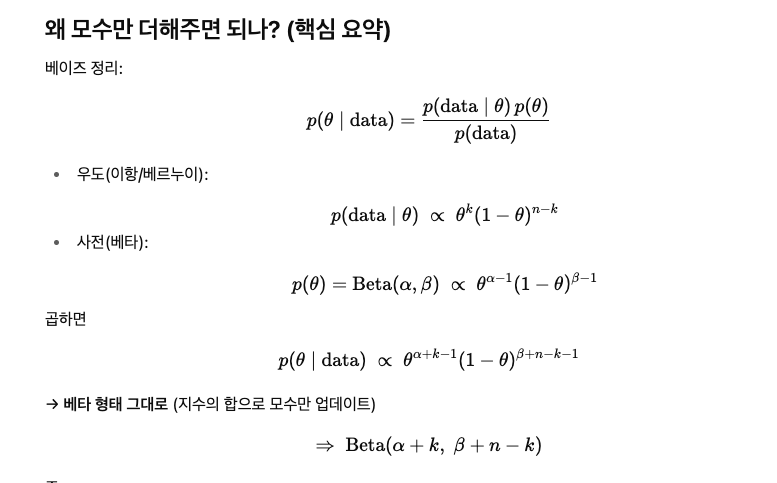

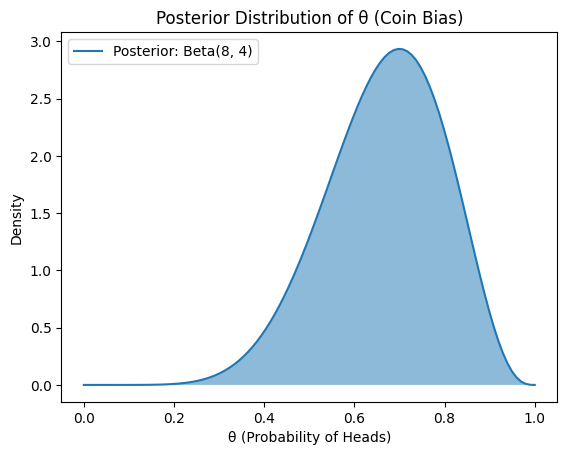

사후 분포의 평균: 0.6666666666666666
사후 분포의 분산: 0.017094017094017096


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# 관찰된 데이터: 10번 던져서 7번 앞면이 나옴
n_trials = 10
n_heads = 7

# # 사전 분포: 균등 분포를 가정 (Beta(1, 1))
# 베타 분포(Beta distribution) 는 확률론과 통계에서 아주 자주 등장하는 연속 확률분포예요.

# 특히 확률이나 비율(0과 1 사이의 값)을 모델링할 때 핵심적으로 쓰입니다.
# 즉, 감마 함수와 직접적으로 연결돼 있어요.
# 그래서 베타 분포는 감마 함수로 정규화된 분포라고 할 수 있습니다.
alpha_prior = 1
beta_prior = 1

# 우도에 따른 사후 분포: Beta(alpha + n_heads, beta + n_trials - n_heads)
alpha_post = alpha_prior + n_heads
beta_post = beta_prior + (n_trials - n_heads)

# 베타 분포를 사용하여 사후 분포 그리기
theta = np.linspace(0, 1, 100)
posterior_dist = beta.pdf(theta, alpha_post, beta_post)

plt.plot(theta, posterior_dist, label=f'Posterior: Beta({alpha_post}, {beta_post})')
plt.fill_between(theta, posterior_dist, alpha=0.5)
plt.title('Posterior Distribution of θ (Coin Bias)')
plt.xlabel('θ (Probability of Heads)')
plt.ylabel('Density')
plt.legend()
plt.show()

# 사후 분포의 평균과 분산 계산
posterior_mean = alpha_post / (alpha_post + beta_post)
posterior_variance = (alpha_post * beta_post) / ((alpha_post + beta_post) ** 2 * (alpha_post + beta_post + 1))

print(f"사후 분포의 평균: {posterior_mean}")
print(f"사후 분포의 분산: {posterior_variance}")

*pymc3 mcmc 예제


사전분포가 정규분포 n(0,1)이고, 관찰된 데이터의 평균이 1, 분산이 0.5, 데이터 수가 10인 경우,
사후분포의 평균, 분산을 구하시오

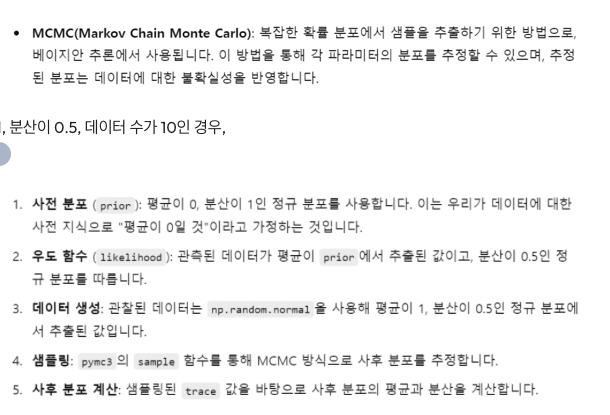

In [1]:
import pymc3 as pm
import numpy as np

observed_mean = 1
observed_var = 0.5
n_data = 10

prior_mean = 0
prior_var = 1

np.random.seed(42)
data = np.random.normal(loc=observed_mean, scale=np.sqrt(observed_var), size=n_data)

# 모델링
with pm.Model() as model:
    prior = pm.Normal('prior', mu=prior_mean, sd=np.sqrt(prior_var))  # 사전분포 설정
    likelihood = pm.Normal('likelihood', mu=prior, sd=np.sqrt(observed_var), observed=data)  # 우도함수 설정
    trace = pm.sample(1000, tune=1000, cores=1)

posterior_mean = np.mean(trace['prior'])  # 추론 결과 요약
posterior_var = np.var(trace['prior'])

print("사후분포의 평균:", posterior_mean)
print("사후분포의 분산:", posterior_var)

The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
/opt/homebrew/Caskroom/miniforge/base/envs/pymc/lib/python3.8/site-packages/deprecat/classic.py:232: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [prior]


/opt/homebrew/Caskroom/miniforge/base/envs/pymc/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


사후분포의 평균: 1.2582868144079076
사후분포의 분산: 0.048823418024184474


*pymc3 이용하지 않고 mcmc 예제

→ Metropolis-Hastings 알고리즘을 이용하여 MCMC 샘플링을 수행

사후분포의 평균: 1.251324230671843
사후분포의 분산: 0.05081217025826958


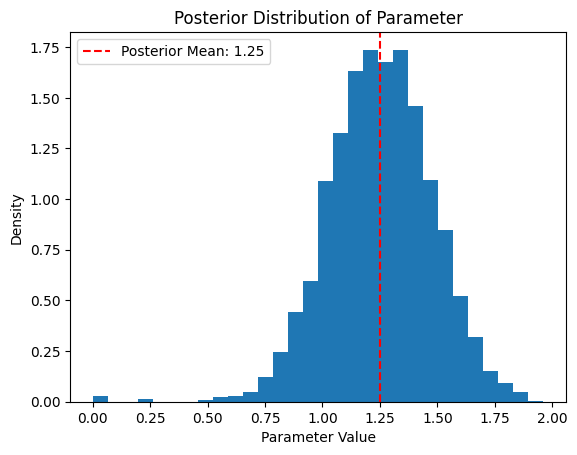

In [2]:
import numpy as np
import matplotlib.pyplot as plt

observed_mean = 1
observed_var = 0.5
n_data = 10

prior_mean = 0
prior_var = 1

np.random.seed(42)
data = np.random.normal(loc=observed_mean, scale=np.sqrt(observed_var), size=n_data)

# 우도 함수: 주어진 파라미터에서 데이터를 관찰할 확률 (정규분포)
def likelihood(param, data):
    return np.prod(1/np.sqrt(2 * np.pi * observed_var) * np.exp(-0.5 * ((data - param)**2) / observed_var))

# 사전 분포: 정규분포 (N(0,1))
def prior(param):
    return (1/np.sqrt(2 * np.pi * prior_var)) * np.exp(-0.5 * ((param - prior_mean)**2) / prior_var)

# 사후 확률 (우도와 사전 확률의 곱)
def posterior(param, data):
    return likelihood(param, data) * prior(param)

# Metropolis-Hastings 샘플링
def metropolis_hastings(data, iterations=10000, initial_value=0):
    samples = []
    current_param = initial_value
    for _ in range(iterations):
        # 새로운 후보 파라미터를 N(현재 파라미터, 0.5^2)에서 샘플링
        proposed_param = np.random.normal(current_param, 0.5)

        # 현재 상태와 제안된 상태에서의 posterior 비율을 계산
        acceptance_ratio = posterior(proposed_param, data) / posterior(current_param, data)
        
        # 제안된 파라미터를 수락할 확률
        if np.random.rand() < min(1, acceptance_ratio):
            current_param = proposed_param
        
        samples.append(current_param)

    return np.array(samples)

# MCMC 수행
samples = metropolis_hastings(data, iterations=5000)

posterior_mean = np.mean(samples)
posterior_var = np.var(samples)

print("사후분포의 평균:", posterior_mean)
print("사후분포의 분산:", posterior_var)

plt.hist(samples, bins=30, density=True)
plt.axvline(posterior_mean, color='r', linestyle='--', label=f"Posterior Mean: {posterior_mean:.2f}")
plt.title('Posterior Distribution of Parameter')
plt.xlabel('Parameter Value')
plt.ylabel('Density')
plt.legend()
plt.show()

In [3]:
import numpy as np

# 사전 분포의 평균과 분산
prior_mean = 0
prior_var = 1

# 관찰된 데이터의 평균과 분산
observed_mean = 1
observed_var = 0.5
n_data = 10  # 데이터의 개수

posterior_var = 1 / (1 / prior_var + n_data / observed_var)
posterior_mean = posterior_var * (prior_mean / prior_var + n_data * observed_mean / observed_var)

print("사후분포의 평균:", posterior_mean)
print("사후분포의 분산:", posterior_var)

사후분포의 평균: 0.9523809523809523
사후분포의 분산: 0.047619047619047616


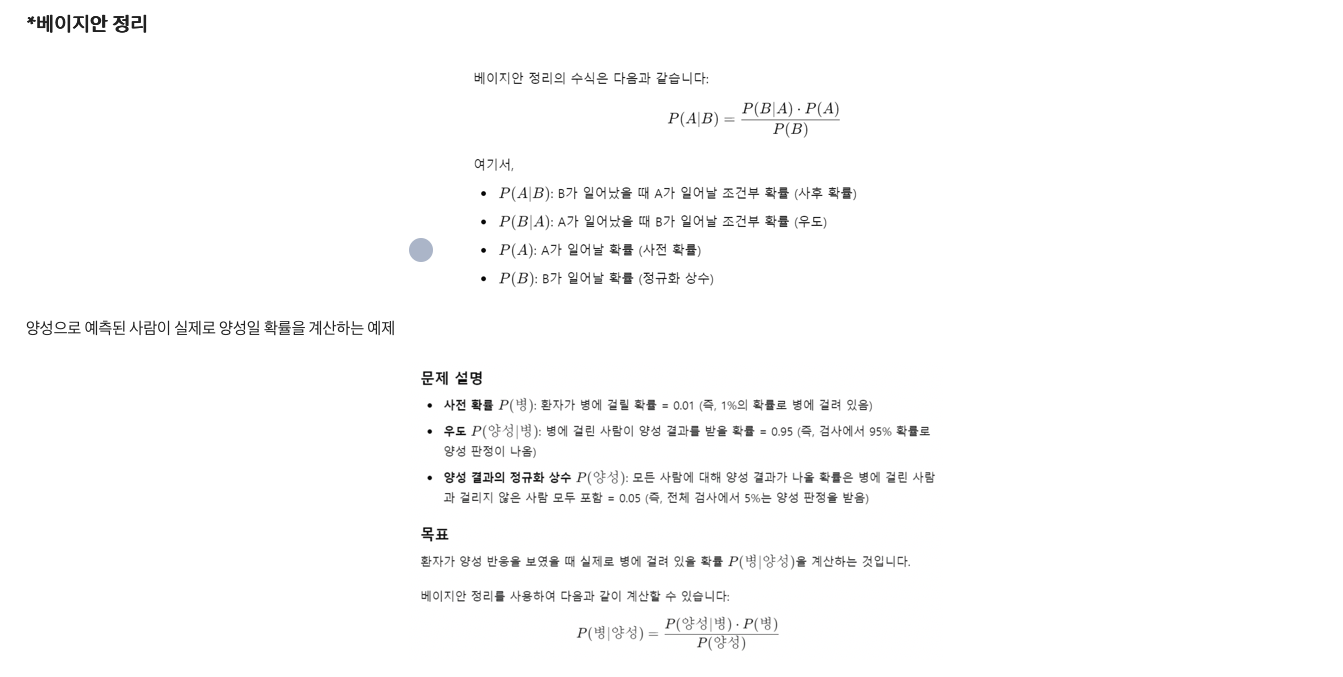

In [4]:
P_disease = 0.01             # 사전 확률: 병에 걸릴 확률
P_positive_given_disease = 0.95  # 우도: 병에 걸린 사람이 양성 판정을 받을 확률
P_positive = 0.05            # 정규화 상수: 양성 결과가 나올 확률 (전체 검사에서)

# 사후 확률 계산
P_disease_given_positive = (P_positive_given_disease * P_disease) / P_positive

# 결과 출력
print(f"양성 반응일 때 실제로 병에 걸려 있을 확률: {P_disease_given_positive:.4f}")

import numpy as np

p_positive_given_positive = 0.9   # P(양성 예측 | 실제 양성) - 민감도 (True Positive Rate)
p_positive = 0.1                  # P(실제 양성) - 사전 확률 (양성일 확률)
p_negative = 1 - p_positive       # P(실제 음성) - 음성일 확률
p_negative_given_negative = 0.85  # P(음성 예측 | 실제 음성) - 특이도 (True Negative Rate)
p_positive_given_negative = 1 - p_negative_given_negative  # P(양성 예측 | 실제 음성) - False Positive Rate

# P(양성 | 양성 예측) 계산
p_positive_predict = (p_positive_given_positive * p_positive) + (p_positive_given_negative * p_negative)
    
# P(양성 | 양성 예측) 계산
result = (p_positive_given_positive * p_positive) / p_positive_predict

print(f"양성으로 예측된 사람이 실제 양성일 확률: {result * 100:.2f}%")

양성 반응일 때 실제로 병에 걸려 있을 확률: 0.1900
양성으로 예측된 사람이 실제 양성일 확률: 40.00%


In [5]:
# *예제1) 모 선출에서 2명의 후보자가 있다. A1, A2가 당선될 확률은 각각 0.7과 0.3이다. A1, A2가 당선되면 각각 0.2와 0.9의 예측 확률로 회비를 인상할 것으로 판단된다. 회원의 회비가 인상될 확률은 얼마인가?

P_A1 = 0.7  # A1이 당선될 확률
P_A2 = 0.3  # A2가 당선될 확률
P_increase_given_A1 = 0.2  # A1이 당선되었을 때 회비 인상 확률
P_increase_given_A2 = 0.9  # A2가 당선되었을 때 회비 인상 확률

P_increase = (P_A1 * P_increase_given_A1) + (P_A2 * P_increase_given_A2)
print(f"회비가 인상될 확률: {P_increase * 100:.2f}%")

회비가 인상될 확률: 41.00%


In [6]:
# 예제2) 기계 A1, A2, A3이 있다. 각 기계는 각각 전 생산량의 20%, 35%, 45%를 생산하고 각 기계의 불량률은 각각 2%, 4%, 3%라고 한다. 제품 하나를 추출하였는데 그 제품이 불량이었다. 이것이 A1, A2, A3 각각에서 만들어졌을 확률은?

P_A1 = 0.2
P_A2 = 0.35
P_A3 = 0.45

P_B_given_A1 = 0.02
P_B_given_A2 = 0.04
P_B_given_A3 = 0.03

# 전체 제품이 불량일 확률 (전체 확률의 법칙)
P_B = (P_A1 * P_B_given_A1) + (P_A2 * P_B_given_A2) + (P_A3 * P_B_given_A3)

# 베이지안 정리를 이용하여 사후 확률 계산
P_A1_given_B = (P_B_given_A1 * P_A1) / P_B
P_A2_given_B = (P_B_given_A2 * P_A2) / P_B
P_A3_given_B = (P_B_given_A3 * P_A3) / P_B

print(f"A1에서 만들어졌을 확률: {P_A1_given_B * 100:.2f}%")
print(f"A2에서 만들어졌을 확률: {P_A2_given_B * 100:.2f}%")
print(f"A3에서 만들어졌을 확률: {P_A3_given_B * 100:.2f}%")

A1에서 만들어졌을 확률: 12.70%
A2에서 만들어졌을 확률: 44.44%
A3에서 만들어졌을 확률: 42.86%


In [ ]:
from scipy.stats import beta

# 사전 확률
p_L1 = 0.6           # 제품이 L1 라인에서 생산될 확률
p_B_L1 = 0.1         # L1 라인의 불량률

# 베타 분포의 사전 모수
prior_alpha = 1
prior_beta = 1

# 관측 정보에 기반한 사후 모수
posterior_alpha = prior_alpha + p_B_L1 * p_L1
posterior_beta = prior_beta + p_L1 - p_B_L1 * p_L1

# 사후 분포 객체
posterior_dist = beta(posterior_alpha, posterior_beta)

# 사후 평균: 불량 제품이 나왔을 때 L1에서 나왔을 확률의 기대값
# 평균을 사용하여 불량 제품이 나왔을 때 L1 라인에서 생산되었을 확률 계산
p_L1_given_B = posterior_dist.mean()  

print("불량 제품이 나왔을 때 L1 라인에서 생산되었을 확률:", round(p_L1_given_B, 4))

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

X, y = np.random.rand(100, 5), np.random.randint(2, size=100)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = GaussianNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# 민감도와 특이도 계산
TP = cm[1, 1]  # True Positive (양성으로 예측했고 실제로도 양성)
FP = cm[0, 1]  # False Positive (양성으로 예측했지만 실제로는 음성)
TN = cm[0, 0]  # True Negative (음성으로 예측했고 실제로도 음성)
FN = cm[1, 0]  # False Negative (음성으로 예측했지만 실제로는 양성)

p_positive_given_positive = TP / (TP + FN)  # P(양성 예측 | 실제 양성) = 민감도
p_negative_given_negative = TN / (TN + FP)  # P(음성 예측 | 실제 음성) = 특이도
p_positive = (TP + FN) / len(y_test)  # P(양성) = 실제 양성일 확률
p_negative = (TN + FP) / len(y_test)  # P(음성) = 실제 음성일 확률
p_positive_given_negative = 1 - p_negative_given_negative  # P(양성 예측 | 실제 음성) = 1 - 특이도 (거짓 양성율)

# 베이즈 정리로 P(실제 양성 | 양성 예측)을 계산
p_positive_predict = (p_positive_given_positive * p_positive) + (p_positive_given_negative * p_negative)
result = (p_positive_given_positive * p_positive) / p_positive_predict
print(f"\n양성으로 예측된 사람이 실제 양성일 확률: {result * 100:.2f}%")

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.27      0.35        15
           1       0.50      0.73      0.59        15

    accuracy                           0.50        30
   macro avg       0.50      0.50      0.47        30
weighted avg       0.50      0.50      0.47        30

Confusion Matrix:
 [[ 4 11]
 [ 4 11]]

양성으로 예측된 사람이 실제 양성일 확률: 50.00%


In [11]:
from scipy import stats

# 1종 오류: 신약에 효과가 없을 때 (H0 참인데 기각하는 경우)
alpha = 0.05  # 유의수준 5%

# 신약에 효과가 없을 때의 분포 (평균 0, 표준편차 1인 정규분포)
null_dist = stats.norm(0, 1)

# 임계값: H0를 기각할 기준
critical_value = null_dist.ppf(1 - alpha)

print(f"1종 오류를 범할 임계값: {critical_value:.2f}")

# 2종 오류: 신약에 실제로 효과가 있는데도 (H1 참인데 기각하지 않는 경우)
effect_size = 0.5  # 신약이 효과가 있을 때의 평균
alternative_dist = stats.norm(effect_size, 1)

# 2종 오류 확률: H1이 참일 때, H0를 기각하지 않을 확률 (beta)
beta = alternative_dist.cdf(critical_value)

print(f"2종 오류 확률 (beta): {beta:.2f}")
print(f"검정력 (1 - beta): {1 - beta:.2f}")

1종 오류를 범할 임계값: 1.64
2종 오류 확률 (beta): 0.87
검정력 (1 - beta): 0.13


In [12]:
import numpy as np
from scipy import stats

# 1. 유의 수준 설정 (alpha)
alpha = 0.05

# 2. 귀무가설과 대립가설의 가정
mu_0 = 0  # 귀무가설의 평균
mu_1 = 0.5  # 대립가설의 평균 (효과 크기)
sigma = 1  # 표준편차
n = 30  # 표본 크기

# 3. 임계값 계산 (1종 오류를 범할 임계값)
z_alpha = stats.norm.ppf(1 - alpha)
critical_value = mu_0 + z_alpha * (sigma / np.sqrt(n))
print(f"임계값: {critical_value:.2f}")

# 4. 대립가설이 참일 때 (mu_1 = 0.5) 검정력 계산
z_beta = (critical_value - mu_1) / (sigma / np.sqrt(n))
power = 1 - stats.norm.cdf(z_beta)
print(f"검정력: {power:.2f}")

# 5. 유의 확률 (p-value) 계산
observed_value = 0.6  # 실제 관측된 값
z_observed = (observed_value - mu_0) / (sigma / np.sqrt(n))
p_value = 1 - stats.norm.cdf(z_observed)
print(f"p-value: {p_value:.3f}")

임계값: 0.30
검정력: 0.86
p-value: 0.001


In [ ]:
import numpy as np
from scipy.stats import invgamma, norm

np.random.seed(1234)

X = np.array([[170, 80], [165, 75], [180, 90], [175, 85], [160, 70]])  # 키, 허리둘레
y = np.array([65, 60, 85, 75, 55])  # 몸무게

# 사전분포: 회귀계수는 부적절한 균일분포를 사용하고, 오차항 분산은 역감마 분포
alpha_prior = 0.005
beta_prior = 0.005

# 오차항 분산의 사전분포로부터 샘플링
sigma2 = invgamma.rvs(a=alpha_prior, scale=beta_prior)

beta = np.random.randn(2)  # 회귀계수 초기값
n_iter = 11000  # 총 MCMC 수행 횟수
burn_in = 1000  # burn-in

# MCMC 저장용 배열
beta_samples = np.zeros((n_iter - burn_in, 2))
sigma2_samples = np.zeros(n_iter - burn_in)

# MCMC (Metropolis-Hastings Algorithm)
for i in range(n_iter):
    # 회귀계수에 대한 사후분포에서 샘플링 (단순한 가우시안 랜덤워크)
    beta_proposal = beta + np.random.normal(0, 0.1, size=beta.shape)
    
    # 제안된 베타로 사후 확률비 계산
    y_pred = X @ beta
    y_pred_proposal = X @ beta_proposal
    likelihood_current = np.sum(norm.logpdf(y, y_pred, np.sqrt(sigma2)))
    likelihood_proposal = np.sum(norm.logpdf(y, y_pred_proposal, np.sqrt(sigma2)))
    
    # 수락/거절 단계
    acceptance_ratio = np.exp(likelihood_proposal - likelihood_current)
    
    if np.random.rand() < acceptance_ratio:
        beta = beta_proposal  # 제안된 베타 수락
    
    # 오차항 분산 sigma^2 업데이트 (Gibbs 샘플링)
    residuals = y - X @ beta
    alpha_post = alpha_prior + len(y) / 2
    beta_post = beta_prior + np.sum(residuals**2) / 2
    sigma2 = invgamma.rvs(a=alpha_post, scale=beta_post)
    
    # burn-in 이후 결과 저장
    if i >= burn_in:
        beta_samples[i - burn_in, :] = beta
        sigma2_samples[i - burn_in] = sigma2

# 회귀계수의 평균 추정값 계산
beta_mean = np.mean(beta_samples, axis=0)
sigma2_mean = np.mean(sigma2_samples)

# 새로운 입력 데이터로 예측
new_data = np.array([180, 85])  # 키 180cm, 허리둘레 85cm 남성
predicted_weight = new_data @ beta_mean

print("추정된 회귀계수 (베타):", beta_mean)
print("추정된 오차항 분산 (시그마^2):", sigma2_mean)
print("예측된 몸무게 (키 180cm, 허리둘레 85cm 남성):", predicted_weight)

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'  #plt.rc('font', family='Malgun Gothic') 
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

fig, axes = plt.subplots(3, 1, figsize=(8, 12))

# 1. 베타(회귀계수) 샘플링 결과 그래프
axes[0].plot(beta_samples[:, 0], label='Beta 1 (키에 대한 계수)', color='blue')
axes[0].plot(beta_samples[:, 1], label='Beta 2 (허리둘레에 대한 계수)', color='green')
axes[0].set_title('MCMC sampling: 회귀계수 Beta 추정')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Beta Value')
axes[0].legend()

# 2. 오차항 분산(sigma^2) 샘플링 결과 그래프
axes[1].plot(sigma2_samples, label='Sigma^2', color='red')
axes[1].set_title('MCMC sampling: 오차항 분산 Sigma^2 추정')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Sigma^2 Value')
axes[1].legend()

# 3. 예측값 그래프
new_data = np.array([180, 85])  # 키 180cm, 허리둘레 85cm 남성
predicted_weight_samples = beta_samples @ new_data

axes[2].hist(predicted_weight_samples, bins=30, color='purple', alpha=0.7)
axes[2].set_title('예측된 몸무게 분포 (키 180cm, 허리둘레 85cm)')
axes[2].set_xlabel('Weight (kg)')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma2, beta]
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
The version of PyMC 

/opt/homebrew/Caskroom/miniforge/base/envs/pymc/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/pymc/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/pymc/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/pymc/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 43 seconds.
There were 896 divergences after tuning. Increase `target_accept` or reparameterize.
The accep

추정된 회귀계수 (베타): [-0.5776444   2.07733159]
추정된 오차항 분산 (시그마^2): 17.005971448325383
예측된 몸무게 (키 180cm, 허리둘레 85cm 남성): 72.5971926759614


Got error No model on context stack. trying to find log_likelihood in translation.


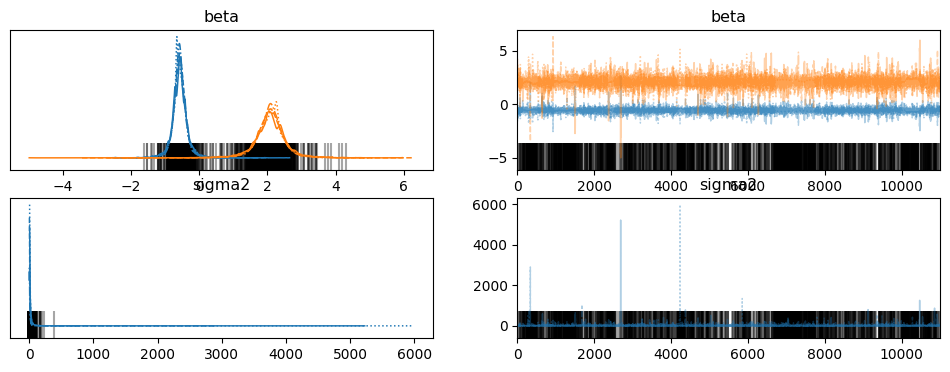

/opt/homebrew/Caskroom/miniforge/base/envs/pymc/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/envs/pymc/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/envs/pymc/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 46108 (\N{HANGUL SYLLABLE DOEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/envs/pymc/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 47800 (\N{HANGUL SYLLABLE MOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/envs/pymc/lib/python3.8/site-packages/IPython/cor

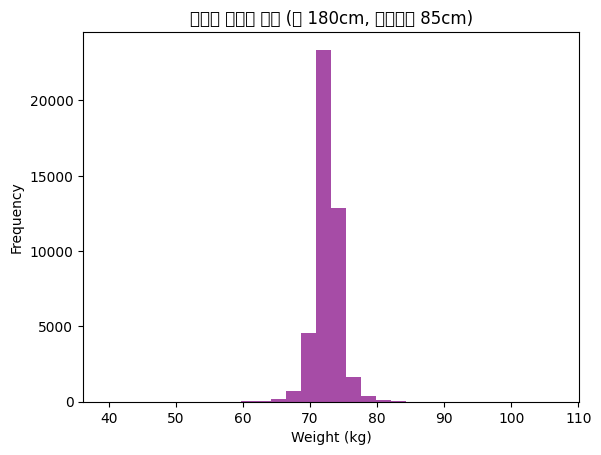

In [13]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt

# 시드 설정
np.random.seed(1234)

# 주어진 데이터를 생성 (키, 허리둘레, 몸무게)
X = np.array([[170, 80], [165, 75], [180, 90], [175, 85], [160, 70]])  # 키, 허리둘레
y = np.array([65, 60, 85, 75, 55])  # 몸무게

# PyMC3 모델 생성
with pm.Model() as model:
    # 회귀계수의 사전분포: 부적절한 균일분포 (정규분포의 표준편차를 매우 크게)
    beta = pm.Normal('beta', mu=0, sigma=1e6, shape=2)
    
    # 오차항 분산의 사전분포: 역감마 분포로 지정
    sigma2 = pm.InverseGamma('sigma2', alpha=0.005, beta=0.005)
    sigma = pm.math.sqrt(sigma2)

    # 선형 모델 정의
    mu = pm.math.dot(X, beta)

    # 관측된 데이터에 대한 우도함수 (정규분포)
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y)

    # 샘플링 (MCMC: NUTS)
    trace = pm.sample(11000, tune=1000, target_accept=0.9, return_inferencedata=False)

# 추정된 회귀계수와 오차항 분산 출력
beta_samples = trace['beta']
sigma2_samples = trace['sigma2']
beta_mean = np.mean(beta_samples, axis=0)
sigma2_mean = np.mean(sigma2_samples)

print("추정된 회귀계수 (베타):", beta_mean)
print("추정된 오차항 분산 (시그마^2):", sigma2_mean)

# 새로운 데이터 (키 180cm, 허리둘레 85cm 남성)의 몸무게 예측
new_data = np.array([180, 85])
predicted_weight = new_data @ beta_mean
print("예측된 몸무게 (키 180cm, 허리둘레 85cm 남성):", predicted_weight)

# 추정된 파라미터의 분포 시각화
pm.traceplot(trace)
plt.show()

# 예측된 몸무게의 분포 시각화
predicted_weight_samples = beta_samples @ new_data
plt.hist(predicted_weight_samples, bins=30, color='purple', alpha=0.7)
plt.title('예측된 몸무게 분포 (키 180cm, 허리둘레 85cm)')
plt.xlabel('Weight (kg)')
plt.ylabel('Frequency')
plt.show()

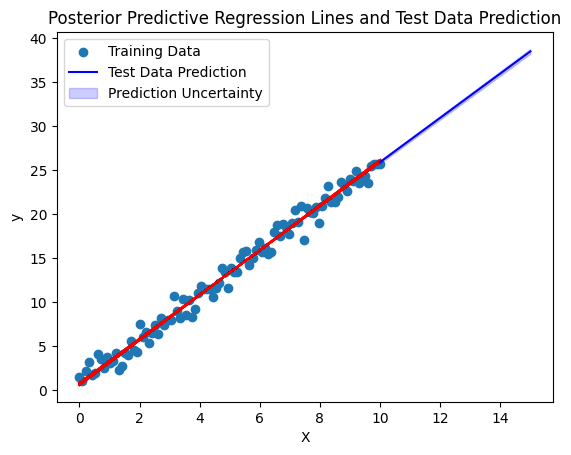

Alpha (Intercept) Posterior Mean: 0.77
Beta (Slope) Posterior Mean: 2.52
Sigma Posterior Mean: 0.89


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, invgamma

np.random.seed(42)
n = 100
X = np.linspace(0, 10, n)
true_slope = 2.5
true_intercept = 1.0
true_sigma = 1.0

y = true_slope * X + true_intercept + np.random.normal(0, true_sigma, size=n)

# 2. 사전 분포 설정 및 최대우도추정(MLE) 계산
alpha_prior_mean = 0
alpha_prior_std = 10
beta_prior_mean = 0
beta_prior_std = 10
sigma_prior_alpha = 1
sigma_prior_beta = 1

# 디자인 매트릭스
X_design = np.vstack([np.ones(n), X]).T
beta_hat = np.linalg.inv(X_design.T @ X_design) @ X_design.T @ y
alpha_mle, beta_mle = beta_hat[0], beta_hat[1]

# 잔차 계산 및 sigma^2의 사후 분포 계산
residuals = y - (beta_mle * X + alpha_mle)
alpha_post = sigma_prior_alpha + n / 2
beta_post = sigma_prior_beta + np.sum(residuals**2) / 2
sigma2_posterior = invgamma.rvs(a=alpha_post, scale=beta_post, size=1)
sigma_posterior = np.sqrt(sigma2_posterior)

# 3. Metropolis-Hastings MCMC 알고리즘
def log_likelihood(alpha, beta, sigma):
    """우도 함수 계산 (로그 형태)"""
    return -0.5 * np.sum(((y - (alpha + beta * X)) / sigma) ** 2) - n * np.log(sigma)

def metropolis_hastings(initial, iterations, step_size):
    alpha_current, beta_current = initial
    samples = np.zeros((iterations, 2))
    for i in range(iterations):
        alpha_proposed = norm.rvs(loc=alpha_current, scale=step_size)
        beta_proposed = norm.rvs(loc=beta_current, scale=step_size)

        # 현재 상태와 제안 상태의 우도를 계산
        ll_current = log_likelihood(alpha_current, beta_current, sigma_posterior)
        ll_proposed = log_likelihood(alpha_proposed, beta_proposed, sigma_posterior)

        # 수용 확률을 계산 (log 형식에서 차를 비교)
        acceptance_ratio = np.exp(ll_proposed - ll_current)
        if np.random.rand() < acceptance_ratio:
            alpha_current, beta_current = alpha_proposed, beta_proposed  # 상태를 업데이트

        samples[i] = [alpha_current, beta_current]
    
    return samples

# MCMC 샘플링 수행
initial_params = [alpha_mle, beta_mle]
iterations = 2000
step_size = 0.5  # MCMC에서 제안 분포의 표준편차
samples = metropolis_hastings(initial_params, iterations, step_size)

# 4. 기울기와 절편의 사후 분포에서 샘플 추출
alpha_samples = samples[:, 0]
beta_samples = samples[:, 1]

# 5. 테스트 데이터 예측
X_test = np.linspace(10, 15, 50)  # 테스트 데이터
Y_test_samples = alpha_samples[:, None] + beta_samples[:, None] * X_test

# 6. 테스트 데이터에 대한 예측값 평균 및 불확실성 계산
Y_test_mean = np.mean(Y_test_samples, axis=0)
Y_test_std = np.std(Y_test_samples, axis=0)

plt.scatter(X, y, label='Training Data')
for i in range(100):
    plt.plot(X, alpha_samples[i] + beta_samples[i] * X, color='red', alpha=0.1)

plt.plot(X_test, Y_test_mean, color='blue', label='Test Data Prediction')
plt.fill_between(X_test, Y_test_mean - Y_test_std, Y_test_mean + Y_test_std, color='blue', alpha=0.2, label='Prediction Uncertainty')
plt.title('Posterior Predictive Regression Lines and Test Data Prediction')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

alpha_mean = np.mean(alpha_samples)
beta_mean = np.mean(beta_samples)
sigma_mean = np.mean(sigma_posterior)

print(f"Alpha (Intercept) Posterior Mean: {alpha_mean:.2f}")
print(f"Beta (Slope) Posterior Mean: {beta_mean:.2f}")
print(f"Sigma Posterior Mean: {sigma_mean:.2f}")

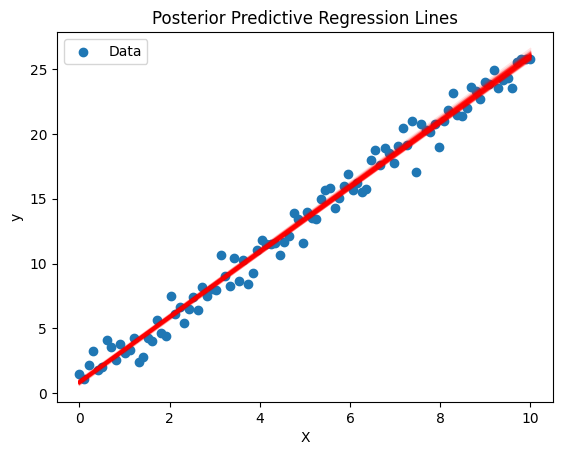

Alpha (Intercept) Posterior Mean: 0.83
Beta (Slope) Posterior Mean: 2.51
Sigma Posterior Mean: 0.91


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, invgamma

np.random.seed(42)
n = 100  # 데이터 포인트 개수
X = np.linspace(0, 10, n)
true_slope = 2.5
true_intercept = 1.0
true_sigma = 1.0

y = true_slope * X + true_intercept + np.random.normal(0, true_sigma, size=n)

# 2. 사전 분포 설정 및 MLE 계산
# 정규분포를 이용해 기울기와 절편의 사전 분포를 설정
alpha_prior_mean = 0
alpha_prior_std = 10
beta_prior_mean = 0
beta_prior_std = 10

# MLE 계산
X_design = np.vstack([np.ones(n), X]).T  # 디자인 매트릭스
beta_hat = np.linalg.inv(X_design.T @ X_design) @ X_design.T @ y
alpha_mle, beta_mle = beta_hat[0], beta_hat[1]

# 잔차 계산
residuals = y - (beta_mle * X + alpha_mle)

# 잔차 제곱합을 이용한 sigma^2 사후 분포 계산
alpha_prior = 1
beta_prior = 1
alpha_post = alpha_prior + n / 2
beta_post = beta_prior + np.sum(residuals**2) / 2
sigma2_posterior = invgamma.rvs(a=alpha_post, scale=beta_post, size=2000)
sigma_posterior = np.sqrt(sigma2_posterior)

# 3. 사후 분포 샘플링
alpha_posterior = norm.rvs(loc=alpha_mle, scale=sigma_posterior / np.sqrt(n), size=2000)
beta_posterior = norm.rvs(loc=beta_mle, scale=sigma_posterior / np.sqrt(np.sum(X**2)), size=2000)

# 4. 사후 확률로 추정된 회귀선 시각화
plt.scatter(X, y, label='Data')
for i in range(100):
    plt.plot(X, alpha_posterior[i] + beta_posterior[i] * X, color='red', alpha=0.1)
plt.title('Posterior Predictive Regression Lines')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

# 기울기와 절편의 사후 확률 요약 통계 확인
alpha_mean = np.mean(alpha_posterior)
beta_mean = np.mean(beta_posterior)
sigma_mean = np.mean(sigma_posterior)

print(f"Alpha (Intercept) Posterior Mean: {alpha_mean:.2f}")
print(f"Beta (Slope) Posterior Mean: {beta_mean:.2f}")
print(f"Sigma Posterior Mean: {sigma_mean:.2f}")

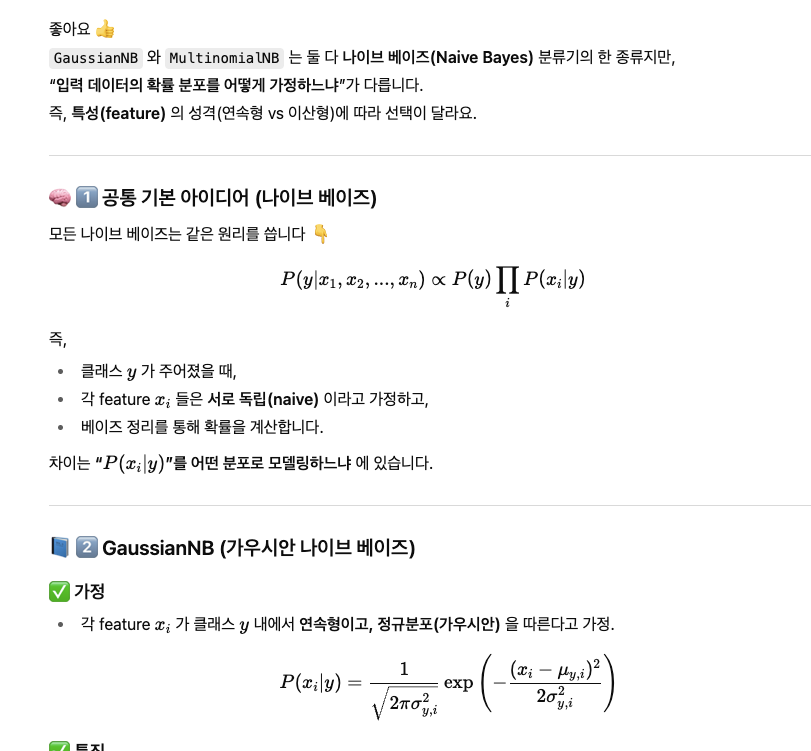

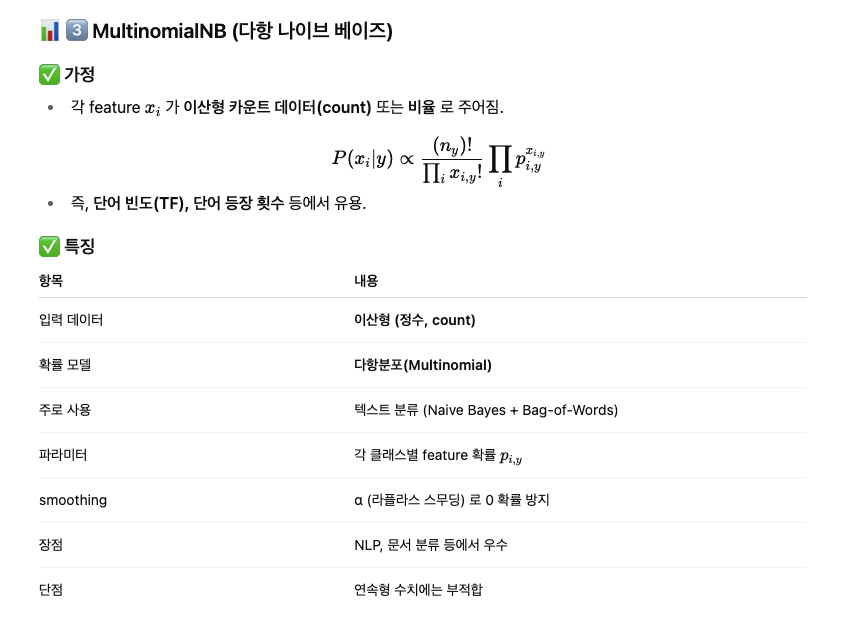

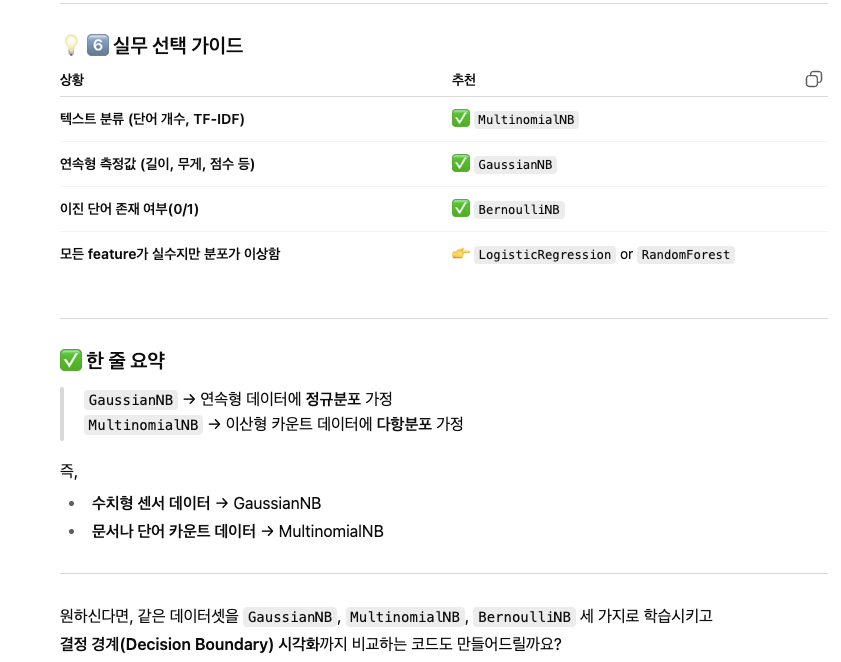